In [1]:
# data wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib

# other
import sklearn
import fairlearn
import torch

# this tutorial has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.24.4  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.8.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.2.1   Your version: %s" % sklearn.__version__)
print("fairlearn     Tested version: 0.10.0  Your version: %s" % fairlearn.__version__)
print("torch         Tested version: 2.2.1   Your version: %s" % torch.__version__)

pandas        Tested version: 2.0.3   Your version: 2.0.3
numpy         Tested version: 1.24.4  Your version: 1.24.4
matplotlib    Tested version: 3.8.3   Your version: 3.8.3
scikit-learn  Tested version: 1.2.1   Your version: 1.2.1
fairlearn     Tested version: 0.10.0  Your version: 0.10.0
torch         Tested version: 2.2.1   Your version: 2.2.1


In [2]:
# data wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, RocCurveDisplay

# fairlearn
from fairlearn.metrics import (
    false_positive_rate,
    false_negative_rate,
    true_positive_rate,
    MetricFrame,
    equalized_odds_difference,
)
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.adversarial import AdversarialFairnessClassifier

In [3]:
# load data
df = pd.read_csv("compas-scores-two-years.csv")
# filter similar to propublica
df = df[
    (df["days_b_screening_arrest"] <= 30)
    & (df["days_b_screening_arrest"] >= -30)
    & (df["is_recid"] != -1)
    & (df["c_charge_degree"] != "O")
    & (df["score_text"] != "N/A")
]
# select two largest groups
df = df[(df["race"] == "African-American") | (df["race"] == "Caucasian")]
# select columns
df = df[
    [
        "sex",
        "age",
        "race",
        "priors_count",
        "juv_fel_count",
        "juv_misd_count",
        "juv_other_count",
        "two_year_recid",
    ]
]
# convert categorical variables to numerical to make suitable for ML model
df = pd.get_dummies(df, drop_first=True)
# define X and y
X = df.drop("two_year_recid", axis=1)
y = df["two_year_recid"]

# split the data in train-validation-test sets; use random_state for reproducibility of the results
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# save sensitive features and drop from X
sensitive_features_train = X_train["race_Caucasian"].copy()
sensitive_features_val = X_val["race_Caucasian"].copy()
sensitive_features_test = X_test["race_Caucasian"].copy()
X_train = X_train.drop("race_Caucasian", axis=1)
X_val = X_val.drop("race_Caucasian", axis=1)
X_test = X_test.drop("race_Caucasian", axis=1)

# inspect dataset
display(X_train.head())
# proportion of positives
print("proportion of positives (train): %.2f" % y_train.mean())

,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,sex_Male
1054,53,2,0,0,0,True
731,36,4,0,0,0,False
5827,56,3,0,0,0,False
44,29,0,0,0,0,True
4475,27,2,0,0,0,True


proportion of positives (train): 0.47


In [4]:
def score(
    y_train,
    y_train_pred,
    y_val,
    y_val_pred,
    sensitive_features_train,
    sensitive_features_val,
    metrics={"accuracy": accuracy_score, "fpr": false_positive_rate, "fnr": false_negative_rate,},
):
    """
    Helper function to evaluate classifiers without too much repetition of code.
    """

    # training set
    mf_train = MetricFrame(
        metrics=metrics,
        y_true=y_train,
        y_pred=y_train_pred,
        sensitive_features=sensitive_features_train,
    )

    # validation set
    mf_val = MetricFrame(
        metrics=metrics,
        y_true=y_val,
        y_pred=y_val_pred,
        sensitive_features=sensitive_features_val,
    )

    # display results
    display(
        pd.concat(
            [mf_train.by_group, mf_val.by_group], keys=["train", "validation"]
        ).unstack(level=0)
    )

    # compute metrics
    print(
        "equalized odds difference (validation): %.2f"
        % equalized_odds_difference(
            y_true=y_val,
            y_pred=y_val_pred,
            sensitive_features=sensitive_features_val,
        )
    )
    print("accuracy (validation): %.2f" % accuracy_score(y_true=y_val, y_pred=y_val_pred))
    return

In [5]:
# Train simple logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# score
score(
    y_train,
    lr.predict(X_train),
    y_val,
    lr.predict(X_val),
    sensitive_features_train,
    sensitive_features_val,
)

accuracy                  fpr                  fnr           
                   train validation     train validation     train validation
race_Caucasian                                                               
False           0.682209   0.659878  0.288462   0.275000  0.343884   0.402390
True            0.670707   0.644518  0.151214   0.151163  0.607945   0.627907

equalized odds difference (validation): 0.23
accuracy (validation): 0.65


In [6]:
# make scoring predictions
y_train_score_lr = pd.Series(lr.predict_proba(X_train)[:, 1], index=X_train.index)
y_val_score_lr = pd.Series(lr.predict_proba(X_val)[:, 1], index=X_val.index)

# get indices for grouping
idx_AA_train = sensitive_features_train[sensitive_features_train==0].index

# get new thresholds based on ROC curve for AA
fpr_AA_train, tpr_AA_train, thresholds_AA_train = roc_curve(
    y_true=y_train[idx_AA_train], y_score=y_train_score_lr[idx_AA_train]
)
new_thr = thresholds_AA_train[(np.abs(fpr_AA_train - 0.15)).argmin()]

print("New decision threshold for African-Americans: %.2f" % new_thr)

New decision threshold for African-Americans: 0.59


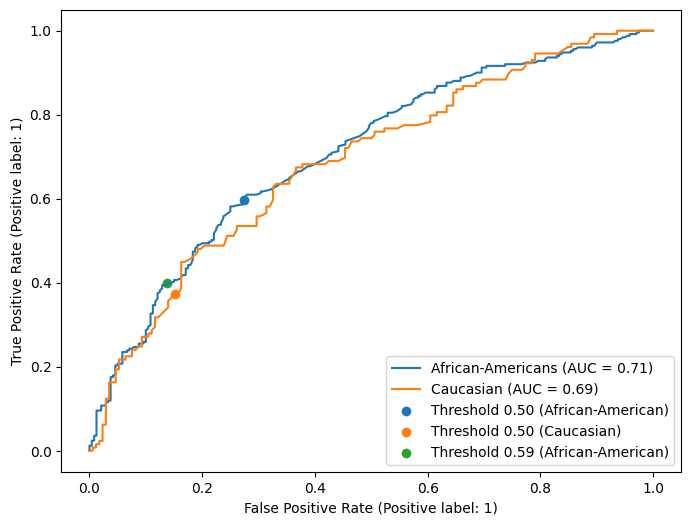

In [7]:
# get remaining indices for grouping
idx_AA_val = sensitive_features_val[sensitive_features_val==0].index
idx_C_val = sensitive_features_val[sensitive_features_val==1].index
idx_C_train = sensitive_features_train[sensitive_features_train==1].index

# plot ROC curves
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

RocCurveDisplay.from_estimator(
    lr,
    X_val.loc[idx_AA_val, :],
    y_val.loc[idx_AA_val],
    name="African-Americans",
    ax=ax,
)

RocCurveDisplay.from_estimator(
    lr,
    X_val.loc[idx_C_val, :],
    y_val.loc[idx_C_val],
    name="Caucasian",
    ax=ax,
)

# add thresholds
plt.scatter(
    false_positive_rate(
        y_true=y_val[idx_AA_val], y_pred=y_val_score_lr[idx_AA_val] >= 0.5
    ),
    true_positive_rate(
        y_true=y_val[idx_AA_val], y_pred=y_val_score_lr[idx_AA_val] >= 0.5
    ),
    label="Threshold 0.50 (African-American)",
)
plt.scatter(
    false_positive_rate(
        y_true=y_val[idx_C_val], y_pred=y_val_score_lr[idx_C_val] >= 0.5
    ),
    true_positive_rate(
        y_true=y_val[idx_C_val], y_pred=y_val_score_lr[idx_C_val] >= 0.5
    ),
    label="Threshold 0.50 (Caucasian)",
)

plt.scatter(
    false_positive_rate(
        y_true=y_val[idx_AA_val], y_pred=y_val_score_lr[idx_AA_val] >= new_thr
    ),
    true_positive_rate(
        y_true=y_val[idx_AA_val], y_pred=y_val_score_lr[idx_AA_val] >= new_thr
    ),
    label="Threshold %.2f (African-American)" % new_thr,
)

plt.legend(loc="lower right")
plt.show()

In [8]:
# make new predictions at two separate decision thresholds
y_train_pred_lr_m = pd.concat(
    [y_train_score_lr[idx_AA_train] >= new_thr, y_train_score_lr[idx_C_train] >= 0.5]
).reindex(X_train.index)

y_val_pred_lr_m = pd.concat(
    [y_val_score_lr[idx_AA_val] >= new_thr, y_val_score_lr[idx_C_val] >= 0.5]
).reindex(X_val.index)

# score
score(
    y_train,
    y_train_pred_lr_m,
    y_val,
    y_val_pred_lr_m,
    sensitive_features_train,
    sensitive_features_val,
)

accuracy                  fpr                  fnr           
                   train validation     train validation     train validation
race_Caucasian                                                               
False           0.639203   0.625255  0.149038   0.137500  0.549187   0.601594
True            0.670707   0.644518  0.151214   0.151163  0.607945   0.627907

equalized odds difference (validation): 0.03
accuracy (validation): 0.63


In [9]:
# train thresholdoptimizer
to = ThresholdOptimizer(
    estimator=lr,
    constraints='equalized_odds',
    predict_method='predict_proba',
    objective='accuracy_score',
)
to.fit(X_train, y_train, sensitive_features=sensitive_features_train)

# score
score(
    y_train,
    to.predict(X_train, sensitive_features=sensitive_features_train, random_state=0),
    y_val,
    to.predict(X_val, sensitive_features=sensitive_features_val, random_state=0),
    sensitive_features_train,
    sensitive_features_val,
)

accuracy                  fpr                  fnr           
                   train validation     train validation     train validation
race_Caucasian                                                               
False           0.626528   0.596741  0.167308   0.162500  0.556886   0.633466
True            0.678788   0.664452  0.174393   0.174419  0.550950   0.550388

equalized odds difference (validation): 0.08
accuracy (validation): 0.62


InterpolatedThresholder(estimator=LogisticRegression(),
                        interpolation_dict={False: {'operation0': [>0.5855255254759701],
                                                    'operation1': [>0.5318328255966378],
                                                    'p0': 0.6666666666666665,
                                                    'p1': 0.3333333333333335,
                                                    'p_ignore': 0.16258623097366856,
                                                    'prediction_constant': 0.17500000000000002},
                                            True: {'operation0': [>0.48339732595857243],
                                                   'operation1': [>0.454107836792059],
                                                   'p0': 0.9915384615384614,
                                                   'p1': 0.008461538461538631,
                                                   'p_ignore': 0.0,
                            

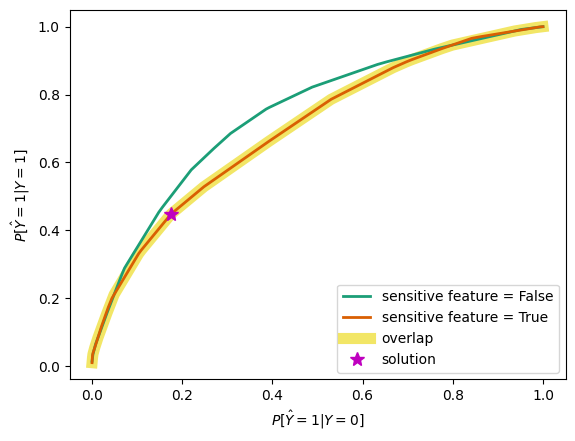

In [10]:
# print solution
print(to.interpolated_thresholder_)

# plot solution
plot_threshold_optimizer(to)

In [11]:
# train adversarial fairness classifier
afc = AdversarialFairnessClassifier(
    backend="torch",
    predictor_model=[50, "leaky_relu"],
    adversary_model=[3, "leaky_relu"],
    constraints='equalized_odds',
    batch_size=8,
    random_state=42
)
afc.fit(X_train, y_train, sensitive_features=sensitive_features_train)

# score
score(
    y_train,
    afc.predict(X_train),
    y_val,
    afc.predict(X_val),
    sensitive_features_train,
    sensitive_features_val,
)

accuracy                  fpr                  fnr           
                   train validation     train validation     train validation
race_Caucasian                                                               
False           0.664554   0.619145  0.390385   0.395833  0.286570   0.366534
True            0.668687   0.637874  0.249448   0.250000  0.459413   0.511628

equalized odds difference (validation): 0.15
accuracy (validation): 0.63
